In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import CuDNNLSTM, CuDNNGRU, Dropout
from keras.optimizers import Adam, SGD
import math
import random
import numpy as np
import json as js
import os

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.utils import to_categorical

# Import own methods

import data_generator_modified as dg
import ml_utils as mlu


from time import sleep

Using TensorFlow backend.


In [2]:
with open("3_cross_validation_organization.json") as json_file:  
    cross_3_val_groups = js.load(json_file)
    print(cross_3_val_groups)

{'group1': [['SA18', 'SA10', 'SA01', 'SA20', 'SA02', 'SA08'], ['SE05', 'SE10', 'SE04', 'SE15']], 'group2': [['SA07', 'SA11', 'SA12', 'SA05', 'SA09', 'SA13', 'SA14'], ['SE02', 'SE01', 'SE13']], 'group3': [['SA04', 'SA06', 'SA17', 'SA21', 'SA23', 'SA16'], ['SE03', 'SE09', 'SE11', 'SE12']]}


In [3]:
from tensorflow.python.client import device_lib
from keras import backend as K

print("Process Units detected by tensorflow: ")
print(device_lib.list_local_devices())


print("GPUs used by keras:")
K.tensorflow_backend._get_available_gpus()

Process Units detected by tensorflow: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7101282634869349719
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10338274888898764712
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3569006901296552761
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10646447719
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16347374520606574829
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
GPUs used by keras:


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
def reduce_frequency_of_window_samples(win_values):
    win_values_with_lower_freq = list()
    for sample in win_values:
        sample_lower_freq = np.array([sample[i] for i in range(len(sample)) if i%2==0])
        win_values_with_lower_freq.append(sample_lower_freq)
    return np.array(win_values_with_lower_freq)

In [5]:
def RnnMmodel(w = 256, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    if not (rnn_type == 'lstm' or rnn_type == 'gru'):
        print("rnn_type must be 'lstm' o  'gru'")
        return
    
    rnn_model = Sequential()
    if (first_dense):
        rnn_model.add(Dense(32, batch_input_shape = (None, w, 3)))
        rnn_model.add(BatchNormalization())
    else:
        rnn_model.add(BatchNormalization(batch_input_shape = (None, w, 3)))
    
    rnn_model.add(Dropout(drop_coeff_rnn))
    
    if two_rnn_layers:
        
        if rnn_type == 'lstm':
            rnn_model.add(CuDNNLSTM((32), return_sequences=True))
        elif rnn_type == 'gru':
            rnn_model.add(CuDNNGRU((32), return_sequences=True))
        
        if(drop_coeff_rnn != 0):
            rnn_model.add(Dropout(drop_coeff_rnn))
    
    if rnn_type == 'lstm':
        rnn_model.add(CuDNNLSTM((32)))
    elif rnn_type == 'gru':
        rnn_model.add(CuDNNGRU((32)))
    
    if(drop_coeff_dense !=0):
        rnn_model.add(Dropout(drop_coeff_dense))
    
    rnn_model.add(Dense(3,activation='softmax'))
    
    return rnn_model
    

In [6]:
def trainRNNModel(dataTrVal, dataTrLab, dataTestVal, dataTestLab, epochs = 100, lr=0.001, w = 256, stride = 128, batch_size = 32, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    dataTrLabelOneHot = to_categorical(dataTrLab)
    dataTestLabelOneHot = to_categorical(dataTestLab)
    
    model = RnnMmodel(w, rnn_type, two_rnn_layers, drop_coeff_rnn, drop_coeff_dense, first_dense)
    
    model.summary()
    
    model_json = model.to_json()
    
    opt_adam = Adam(lr=lr)
    
    model.compile(optimizer=opt_adam, loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

    model_json = model.to_json()

    model_train_history = model.fit(dataTrVal, dataTrLabelOneHot, batch_size=batch_size, epochs=epochs, validation_data = (dataTestVal, dataTestLabelOneHot))

    model_prediction = model.predict(dataTestVal)

    model_confusion_matrix = confusion_matrix(dataTestLab, np.argmax(model_prediction, axis = 1))

    return model, model_train_history, model_confusion_matrix

## Empezamos

Recordar que el grupo 1 va a ser el conjunto de validación. Con los otros 4 se hace el cross validation

### Primer grupo del cross val (grupo 1)

In [45]:
dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../3_cross_validation/group_1/', nTestUsers=8, windowSize=256, stride=128, randomOrder = False, usersForValidation = cross_3_val_groups['group1'])


Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [46]:
set([x[0] for x in dataWinOrganization['test']])

{'SA01',
 'SA02',
 'SA08',
 'SA10',
 'SA18',
 'SA20',
 'SE04',
 'SE05',
 'SE10',
 'SE15'}

In [47]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)

{0: 59570, 1: 830, 2: 2152}
59570 830 2152
[1, 71.7710843373494, 27.681226765799256]


In [48]:
###############################################################
#
# The loss function implemented doesn't work with int targets
from keras.utils import to_categorical

dataTrWinLabelOneHot = to_categorical(dataTrWinLabel)
dataTestWinLabelOneHot = to_categorical(dataTestWinLabel)

###############################################################

In [49]:
import pandas as pd

route = '../3_cross_validation/group_1/'
model_base_name = 'researchset_cross_val_g1'

lstm_params = ['lstm', 0.001, 32, 0.35, 0.0]
gru_params = ['gru', 0.001, 64, 0.35, 0.2]

frequencies = ['200Hz', '100Hz', '50Hz', '25Hz']
frequency_widths = [256, 128, 64, 32]
frequency_strides = [128, 64, 32, 16]
# Creacion del data_frame con los datos

columns_names = ['model_id', 'frequency', 'w', 'stride', 'rnn_type', 'lr', 'batch_size', 'rnn_dropout', 'dense_dropout']

info_list = list()
model_id = 1
for i_f in range(3): # '200Hz', '100Hz', '50Hz', '25Hz'
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      lstm_params[0], lstm_params[1], lstm_params[2], lstm_params[3], lstm_params[4]])
    model_id = model_id +1
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      gru_params[0], gru_params[1], gru_params[2], gru_params[3], gru_params[4]])
    model_id = model_id +1

info_dataframe = pd.DataFrame(info_list, columns = columns_names)
info_dataframe.to_csv(route+model_base_name + '_research_summary.csv', index=False)

model_id = 1

for i_f in range(4):
    
    if i_f == 3:
        # LSTM
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=lstm_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = lstm_params[2], rnn_type = lstm_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=lstm_params[3], drop_coeff_dense=lstm_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group1, 6 adults, 4 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
    
    model_id = model_id +1

    if i_f == 3:
        # GRU
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=gru_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = gru_params[2], rnn_type = gru_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=gru_params[3], drop_coeff_dense=gru_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group1, 6 adults, 4 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
    
    model_id = model_id +1
    
    # Reducing the frequency
    dataTrWinValues = reduce_frequency_of_window_samples(dataTrWinValues)
    dataTestWinValues = reduce_frequency_of_window_samples(dataTestWinValues)
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 32, 3)             12        
_________________________________________________________________
dropout_28 (Dropout)         (None, 32, 3)             0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 32)                4736      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________
Train on 62552 samples, validate on 29842 samples
Epoch 1/150
62552/62552 [==============================] - 15s 241us/step - loss: 2.0733 - acc: 0.6379 - val_loss: 1.4235 - val_acc: 0.8561
Epoch 2/150
62552/62552 [==============================] - 14s 216us/step - loss: 

Epoch 53/150
62552/62552 [==============================] - 13s 205us/step - loss: 0.6483 - acc: 0.9220 - val_loss: 1.0301 - val_acc: 0.9632
Epoch 54/150
62552/62552 [==============================] - 13s 203us/step - loss: 0.6436 - acc: 0.9183 - val_loss: 1.2783 - val_acc: 0.9680
Epoch 55/150
62552/62552 [==============================] - 13s 205us/step - loss: 0.6520 - acc: 0.9220 - val_loss: 1.0583 - val_acc: 0.9660
Epoch 56/150
62552/62552 [==============================] - 13s 206us/step - loss: 0.6488 - acc: 0.9238 - val_loss: 0.9676 - val_acc: 0.9647
Epoch 57/150
62552/62552 [==============================] - 13s 204us/step - loss: 0.6463 - acc: 0.9230 - val_loss: 0.9929 - val_acc: 0.9660
Epoch 58/150
62552/62552 [==============================] - 13s 205us/step - loss: 0.6331 - acc: 0.9263 - val_loss: 0.9399 - val_acc: 0.9643
Epoch 59/150
62552/62552 [==============================] - 13s 204us/step - loss: 0.6482 - acc: 0.9239 - val_loss: 1.0668 - val_acc: 0.9623
Epoch 60/150


62552/62552 [==============================] - 13s 207us/step - loss: 0.5583 - acc: 0.9325 - val_loss: 1.0687 - val_acc: 0.9619
Epoch 112/150
62552/62552 [==============================] - 13s 205us/step - loss: 0.5650 - acc: 0.9326 - val_loss: 0.9614 - val_acc: 0.9628
Epoch 113/150
62552/62552 [==============================] - 13s 204us/step - loss: 0.5493 - acc: 0.9316 - val_loss: 1.0038 - val_acc: 0.9639
Epoch 114/150
62552/62552 [==============================] - 13s 203us/step - loss: 0.5628 - acc: 0.9312 - val_loss: 0.9743 - val_acc: 0.9663
Epoch 115/150
62552/62552 [==============================] - 13s 204us/step - loss: 0.5435 - acc: 0.9304 - val_loss: 0.9410 - val_acc: 0.9649
Epoch 116/150
62552/62552 [==============================] - 13s 204us/step - loss: 0.5321 - acc: 0.9342 - val_loss: 0.9281 - val_acc: 0.9670
Epoch 117/150
62552/62552 [==============================] - 13s 207us/step - loss: 0.5141 - acc: 0.9309 - val_loss: 1.0112 - val_acc: 0.9629
Epoch 118/150
62552/

62552/62552 [==============================] - 7s 107us/step - loss: 0.6800 - acc: 0.9214 - val_loss: 0.9408 - val_acc: 0.9659
Epoch 70/150
62552/62552 [==============================] - 7s 107us/step - loss: 0.6921 - acc: 0.9262 - val_loss: 1.0170 - val_acc: 0.9626
Epoch 71/150
62552/62552 [==============================] - 7s 106us/step - loss: 0.6862 - acc: 0.9239 - val_loss: 0.8937 - val_acc: 0.9536
Epoch 72/150
62552/62552 [==============================] - 7s 107us/step - loss: 0.6726 - acc: 0.9201 - val_loss: 0.8993 - val_acc: 0.9622
Epoch 73/150
62552/62552 [==============================] - 7s 107us/step - loss: 0.6872 - acc: 0.9208 - val_loss: 0.8172 - val_acc: 0.9623
Epoch 74/150
62552/62552 [==============================] - 7s 107us/step - loss: 0.6605 - acc: 0.9220 - val_loss: 0.7834 - val_acc: 0.9569
Epoch 75/150
62552/62552 [==============================] - 7s 107us/step - loss: 0.6932 - acc: 0.9221 - val_loss: 0.8760 - val_acc: 0.9642
Epoch 76/150
62552/62552 [=======

### Extrayendo resultados

In [88]:
import pandas as pd
# from keras.models import load_model

route = '../3_cross_validation/group_1/'
model_base_name = 'researchset_cross_val_g1'


In [16]:
research_set_table = pd.read_csv(route + model_base_name + '_research_summary.csv')
research_set_table

,model_id,frequency,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout
0,1,200Hz,256,128,lstm,0.001,32,0.35,0.0
1,2,200Hz,256,128,gru,0.001,64,0.35,0.2
2,3,100Hz,128,64,lstm,0.001,32,0.35,0.0
3,4,100Hz,128,64,gru,0.001,64,0.35,0.2
4,5,50Hz,64,32,lstm,0.001,32,0.35,0.0
5,6,50Hz,64,32,gru,0.001,64,0.35,0.2


In [89]:
ex_model_info = np.load(route + model_base_name +  '_model_id_5_info.npy')
ex_model_info = ex_model_info[()]

train_results = ex_model_info['train_history']
ex_model_info['eval_results']

array([[27525,   911,   116],
       [   56,   218,     7],
       [   33,    89,   887]])

Confusion matrix, without normalization
[[27525   911   116]
 [   56   218     7]
 [   33    89   887]]
Normalized confusion matrix
[[0.96 0.03 0.  ]
 [0.2  0.78 0.02]
 [0.03 0.09 0.88]]


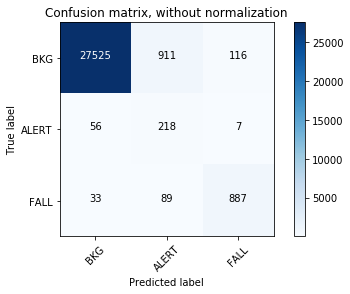

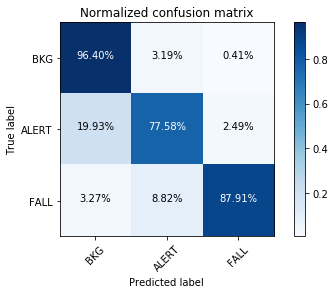

In [44]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Final result

In [29]:
print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][-1], train_results['val_acc'][-1]))

val_loss: 1.0491629085875773, val_acc: 0.9659540245291871


#### Best results

In [31]:
best_loss_result_index = np.argmin(train_results['val_loss'])
best_acc_result_index = np.argmax(train_results['val_acc'])
print('With best accuracy: ')
print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_loss_result_index], train_results['val_acc'][best_loss_result_index]))
print('With best loss: ')
print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_acc_result_index], train_results['val_acc'][best_acc_result_index]))

With best accuracy: 
val_loss: 0.7356786407609203, val_acc: 0.932243147242142
With best loss: 
val_loss: 1.0491629085875773, val_acc: 0.9659540245291871


#### All in one

In [38]:
for i in range(6):
    
    _id = i+1
    print('Model #{}:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    train_results = ex_model_info['train_history']
    
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][-1], train_results['val_acc'][-1]))
    
    best_loss_result_index = np.argmin(train_results['val_loss'])
    best_acc_result_index = np.argmax(train_results['val_acc'])
    print('With best loss: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_loss_result_index], train_results['val_acc'][best_loss_result_index]))
    print('With best accuracy: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_acc_result_index], train_results['val_acc'][best_acc_result_index]))

Model #1:
val_loss: 1.0491629085875773, val_acc: 0.9659540245291871
With best loss: 
val_loss: 0.7356786407609203, val_acc: 0.932243147242142
With best accuracy: 
val_loss: 1.0491629085875773, val_acc: 0.9659540245291871
Model #2:
val_loss: 1.0371443635536481, val_acc: 0.9660880638026942
With best loss: 
val_loss: 0.9714676549441718, val_acc: 0.9588499430333087
With best accuracy: 
val_loss: 1.4836613376623071, val_acc: 0.9741974398498761
Model #3:
val_loss: 0.9515126332525551, val_acc: 0.9625695328731319
With best loss: 
val_loss: 0.7629268248484665, val_acc: 0.9040613899872663
With best accuracy: 
val_loss: 0.9688851241007118, val_acc: 0.9659875343475638
Model #4:
val_loss: 0.9761285273096449, val_acc: 0.9588834528516855
With best loss: 
val_loss: 0.8925222115960427, val_acc: 0.9558005495610213
With best accuracy: 
val_loss: 1.25878312960694, val_acc: 0.9716506936532404
Model #5:
val_loss: 0.7928648412521739, val_acc: 0.9593861001273373
With best loss: 
val_loss: 0.7583360269833744, 

Confusion matrix, without normalization
[[27525   911   116]
 [   56   218     7]
 [   33    89   887]]
Normalized confusion matrix
[[0.96 0.03 0.  ]
 [0.2  0.78 0.02]
 [0.03 0.09 0.88]]


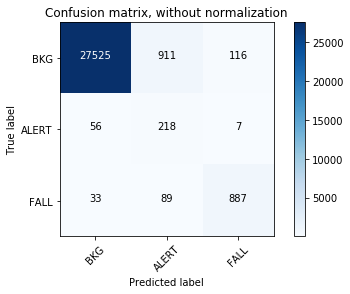

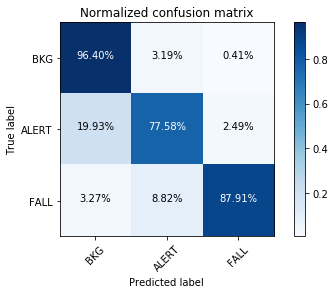

In [44]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [90]:
for i in range(8):
    
    _id = i+1
    print('Model #{} acc:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    eval_results = ex_model_info['eval_results']
    
    acc_bkg = eval_results[0][0]/sum(eval_results[0])
    acc_ale = eval_results[1][1]/sum(eval_results[1])
    acc_fal = eval_results[2][2]/sum(eval_results[2])
    acc_mean = (acc_bkg + acc_ale + acc_fal)/3
    
    print('BKG: {}, ALERT: {}, FALL: {}, mean: {}'.format(acc_bkg, acc_ale, acc_fal, acc_mean))

Model #1 acc:
BKG: 0.9712804707200896, ALERT: 0.7580071174377224, FALL: 0.8731417244796829, mean: 0.8674764375458316
Model #2 acc:
BKG: 0.9728565424488652, ALERT: 0.7829181494661922, FALL: 0.8255698711595639, mean: 0.8604481876915404
Model #3 acc:
BKG: 0.9676029700196134, ALERT: 0.7758007117437722, FALL: 0.8721506442021804, mean: 0.871851441988522
Model #4 acc:
BKG: 0.9647310170916223, ALERT: 0.8113879003558719, FALL: 0.8344895936570862, mean: 0.8702028370348601
Model #5 acc:
BKG: 0.9640305407677221, ALERT: 0.7758007117437722, FALL: 0.8790882061446977, mean: 0.8729731528853973
Model #6 acc:
BKG: 0.9577612776688148, ALERT: 0.7758007117437722, FALL: 0.8939544103072349, mean: 0.8758387999066072
Model #7 acc:
BKG: 0.9686887083216588, ALERT: 0.7900355871886121, FALL: 0.889990089197225, mean: 0.8829047949024987
Model #8 acc:
BKG: 0.9603180162510507, ALERT: 0.7935943060498221, FALL: 0.8394449950445986, mean: 0.8644524391151571


### Primer grupo del cross val (grupo 2)

In [50]:
print('Group 2')
sleep(15)

dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../3_cross_validation/group_2/', nTestUsers=8, windowSize=256, stride=128, randomOrder = False, usersForValidation = cross_3_val_groups['group2'])


Group 2
Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [51]:
set([x[0] for x in dataWinOrganization['test']])

{'SA05',
 'SA07',
 'SA09',
 'SA11',
 'SA12',
 'SA13',
 'SA14',
 'SE01',
 'SE02',
 'SE13'}

In [52]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)

{0: 57285, 1: 753, 2: 1987}
57285 753 1987
[1, 76.07569721115537, 28.829894313034725]


In [53]:
import pandas as pd

route = '../3_cross_validation/group_2/'
model_base_name = 'researchset_cross_val_g2'

lstm_params = ['lstm', 0.001, 32, 0.35, 0.0]
gru_params = ['gru', 0.001, 64, 0.35, 0.2]

frequencies = ['200Hz', '100Hz', '50Hz', '25Hz']
frequency_widths = [256, 128, 64, 32]
frequency_strides = [128, 64, 32, 16]
# Creacion del data_frame con los datos

columns_names = ['model_id', 'frequency', 'w', 'stride', 'rnn_type', 'lr', 'batch_size', 'rnn_dropout', 'dense_dropout']

info_list = list()
model_id = 1
for i_f in range(4): # '200Hz', '100Hz', '50Hz', '25Hz'
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      lstm_params[0], lstm_params[1], lstm_params[2], lstm_params[3], lstm_params[4]])
    model_id = model_id +1
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      gru_params[0], gru_params[1], gru_params[2], gru_params[3], gru_params[4]])
    model_id = model_id +1

info_dataframe = pd.DataFrame(info_list, columns = columns_names)
info_dataframe.to_csv(route+model_base_name + '_research_summary.csv', index=False)

model_id = 1

for i_f in range(4):
    if i_f == 3:
        # LSTM
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=lstm_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = lstm_params[2], rnn_type = lstm_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=lstm_params[3], drop_coeff_dense=lstm_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group2, 7 adults, 3 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')

    model_id = model_id +1
    if i_f == 3:
        # GRU
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=gru_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = gru_params[2], rnn_type = gru_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=gru_params[3], drop_coeff_dense=gru_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group2, 7 adults, 3 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
    
    model_id = model_id +1
    
    # Reducing the frequency
    dataTrWinValues = reduce_frequency_of_window_samples(dataTrWinValues)
    dataTestWinValues = reduce_frequency_of_window_samples(dataTestWinValues)
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 32, 3)             12        
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 3)             0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 32)                4736      
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________
Train on 60025 samples, validate on 32369 samples
Epoch 1/150
60025/60025 [==============================] - 15s 253us/step - loss: 2.2191 - acc: 0.5930 - val_loss: 1.7396 - val_acc: 0.7241
Epoch 2/150
60025/60025 [==============================] - 13s 209us/step - loss: 

Epoch 53/150
60025/60025 [==============================] - 13s 214us/step - loss: 0.7194 - acc: 0.9132 - val_loss: 0.9096 - val_acc: 0.9588
Epoch 54/150
60025/60025 [==============================] - 13s 213us/step - loss: 0.6634 - acc: 0.9148 - val_loss: 1.0714 - val_acc: 0.9582
Epoch 55/150
60025/60025 [==============================] - 13s 215us/step - loss: 0.6815 - acc: 0.9151 - val_loss: 0.9700 - val_acc: 0.9589
Epoch 56/150
60025/60025 [==============================] - 13s 215us/step - loss: 0.7010 - acc: 0.9201 - val_loss: 0.9589 - val_acc: 0.9644
Epoch 57/150
60025/60025 [==============================] - 13s 214us/step - loss: 0.6896 - acc: 0.9142 - val_loss: 0.9757 - val_acc: 0.9609
Epoch 58/150
60025/60025 [==============================] - 13s 214us/step - loss: 0.6705 - acc: 0.9169 - val_loss: 0.8478 - val_acc: 0.9496
Epoch 59/150
60025/60025 [==============================] - 13s 211us/step - loss: 0.6811 - acc: 0.9130 - val_loss: 0.8824 - val_acc: 0.9518
Epoch 60/150


60025/60025 [==============================] - 13s 212us/step - loss: 0.5659 - acc: 0.9281 - val_loss: 0.9367 - val_acc: 0.9562
Epoch 112/150
60025/60025 [==============================] - 13s 214us/step - loss: 0.6109 - acc: 0.9242 - val_loss: 0.8372 - val_acc: 0.9530
Epoch 113/150
60025/60025 [==============================] - 13s 217us/step - loss: 0.6250 - acc: 0.9247 - val_loss: 0.9367 - val_acc: 0.9588
Epoch 114/150
60025/60025 [==============================] - 13s 215us/step - loss: 0.5881 - acc: 0.9221 - val_loss: 0.9687 - val_acc: 0.9433
Epoch 115/150
60025/60025 [==============================] - 13s 213us/step - loss: 0.5931 - acc: 0.9243 - val_loss: 0.9344 - val_acc: 0.9592
Epoch 116/150
60025/60025 [==============================] - 13s 213us/step - loss: 0.6097 - acc: 0.9219 - val_loss: 0.9074 - val_acc: 0.9546
Epoch 117/150
60025/60025 [==============================] - 13s 213us/step - loss: 0.5915 - acc: 0.9229 - val_loss: 0.9221 - val_acc: 0.9565
Epoch 118/150
60025/

60025/60025 [==============================] - 7s 112us/step - loss: 0.7490 - acc: 0.9043 - val_loss: 0.9619 - val_acc: 0.9608
Epoch 70/150
60025/60025 [==============================] - 7s 110us/step - loss: 0.7066 - acc: 0.9083 - val_loss: 0.9828 - val_acc: 0.9584
Epoch 71/150
60025/60025 [==============================] - 7s 110us/step - loss: 0.7179 - acc: 0.9096 - val_loss: 1.0954 - val_acc: 0.9641
Epoch 72/150
60025/60025 [==============================] - 7s 111us/step - loss: 0.7120 - acc: 0.9103 - val_loss: 0.9576 - val_acc: 0.9579
Epoch 73/150
60025/60025 [==============================] - 7s 113us/step - loss: 0.7493 - acc: 0.9109 - val_loss: 0.9975 - val_acc: 0.9571
Epoch 74/150
60025/60025 [==============================] - 7s 110us/step - loss: 0.6919 - acc: 0.9081 - val_loss: 0.9151 - val_acc: 0.9622
Epoch 75/150
60025/60025 [==============================] - 7s 111us/step - loss: 0.7309 - acc: 0.9082 - val_loss: 0.9562 - val_acc: 0.9641
Epoch 76/150
60025/60025 [=======

### Extrayendo resultados

In [85]:
import pandas as pd
# from keras.models import load_model

route = '../3_cross_validation/group_2/'
model_base_name = 'researchset_cross_val_g2'


In [40]:
research_set_table = pd.read_csv(route + model_base_name + '_research_summary.csv')
research_set_table

,model_id,frequency,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout
0,1,200Hz,256,128,lstm,0.001,32,0.35,0.0
1,2,200Hz,256,128,gru,0.001,64,0.35,0.2
2,3,100Hz,128,64,lstm,0.001,32,0.35,0.0
3,4,100Hz,128,64,gru,0.001,64,0.35,0.2
4,5,50Hz,64,32,lstm,0.001,32,0.35,0.0
5,6,50Hz,64,32,gru,0.001,64,0.35,0.2


#### Resultados sobre el historial de entrenamiento

In [41]:
for i in range(6):
    
    _id = i+1
    print('Model #{}:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    train_results = ex_model_info['train_history']
    
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][-1], train_results['val_acc'][-1]))
    
    best_loss_result_index = np.argmin(train_results['val_loss'])
    best_acc_result_index = np.argmax(train_results['val_acc'])
    print('With best loss: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_loss_result_index], train_results['val_acc'][best_loss_result_index]))
    print('With best accuracy: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_acc_result_index], train_results['val_acc'][best_acc_result_index]))

Model #1:
val_loss: 0.7992254976206654, val_acc: 0.9467700577713244
With best loss: 
val_loss: 0.7413021528218657, val_acc: 0.959003985294572
With best accuracy: 
val_loss: 1.0056087193752414, val_acc: 0.962803917328308
Model #2:
val_loss: 1.2997328397317593, val_acc: 0.9337637863074769
With best loss: 
val_loss: 1.1702483789580707, val_acc: 0.9154128950686409
With best accuracy: 
val_loss: 1.870637426040413, val_acc: 0.9639778800704377
Model #3:
val_loss: 1.1061512712818107, val_acc: 0.931477648367265
With best loss: 
val_loss: 0.8548274333260346, val_acc: 0.9465846952330934
With best accuracy: 
val_loss: 1.2895988903468092, val_acc: 0.9629274923537953
Model #4:
val_loss: 1.181385509111603, val_acc: 0.948469214401238
With best loss: 
val_loss: 0.9045682512880874, val_acc: 0.9523618277040895
With best accuracy: 
val_loss: 1.2320086432754904, val_acc: 0.9654916741326578
Model #5:
val_loss: 0.9352869438108464, val_acc: 0.9542463468151504
With best loss: 
val_loss: 0.7956199209742721, val

In [86]:
ex_model_info = np.load(route + model_base_name +  '_model_id_8_info.npy')
ex_model_info = ex_model_info[()]

train_results = ex_model_info['train_history']
ex_model_info['eval_results']

array([[29670,   994,   173],
       [   48,   301,     9],
       [   53,   100,  1021]])

Confusion matrix, without normalization
[[29670   994   173]
 [   48   301     9]
 [   53   100  1021]]
Normalized confusion matrix
[[0.96 0.03 0.01]
 [0.13 0.84 0.03]
 [0.05 0.09 0.87]]


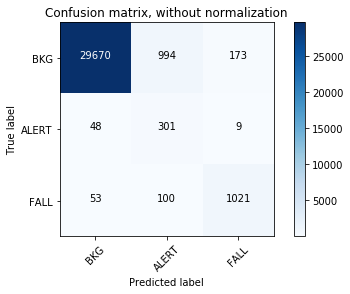

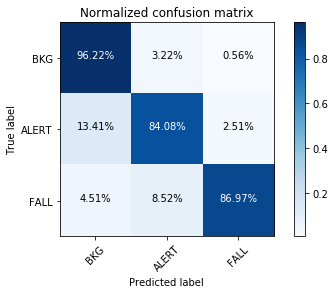

In [61]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [87]:
for i in range(8):
    
    _id = i+1
    print('Model #{} acc:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    eval_results = ex_model_info['eval_results']
    
    acc_bkg = eval_results[0][0]/sum(eval_results[0])
    acc_ale = eval_results[1][1]/sum(eval_results[1])
    acc_fal = eval_results[2][2]/sum(eval_results[2])
    acc_mean = (acc_bkg + acc_ale + acc_fal)/3
    
    print('BKG: {}, ALERT: {}, FALL: {}, mean: {}'.format(acc_bkg, acc_ale, acc_fal, acc_mean))

Model #1 acc:
BKG: 0.9502869928981419, ALERT: 0.8966480446927374, FALL: 0.8696763202725724, mean: 0.9055371192878172
Model #2 acc:
BKG: 0.9393909913415702, ALERT: 0.8743016759776536, FALL: 0.8040885860306644, mean: 0.8725937511166295
Model #3 acc:
BKG: 0.9362454194636314, ALERT: 0.8798882681564246, FALL: 0.8219761499148212, mean: 0.879369945844959
Model #4 acc:
BKG: 0.9550215650030807, ALERT: 0.8100558659217877, FALL: 0.8185689948892675, mean: 0.8612154752713786
Model #5 acc:
BKG: 0.9581347083049583, ALERT: 0.8212290502793296, FALL: 0.8926746166950597, mean: 0.8906794584264492
Model #6 acc:
BKG: 0.9413691344813049, ALERT: 0.8603351955307262, FALL: 0.8705281090289608, mean: 0.8907441463469973
Model #7 acc:
BKG: 0.9511625644517949, ALERT: 0.8966480446927374, FALL: 0.8705281090289608, mean: 0.9061129060578311
Model #8 acc:
BKG: 0.9621558517365503, ALERT: 0.840782122905028, FALL: 0.8696763202725724, mean: 0.89087143163805


### Primer grupo del cross val (grupo 3)

In [7]:
print('Group 3')
sleep(15)


dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../3_cross_validation/group_3/', nTestUsers=8, windowSize=256, stride=128, randomOrder = False, usersForValidation = cross_3_val_groups['group3'])


Group 3
Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [8]:
set([x[0] for x in dataWinOrganization['test']])

{'SA04',
 'SA06',
 'SA16',
 'SA17',
 'SA21',
 'SA23',
 'SE03',
 'SE09',
 'SE11',
 'SE12'}

In [9]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)

{0: 59389, 1: 639, 2: 2183}
59389 639 2183
[1, 92.94053208137716, 27.205222171323868]


In [10]:
import pandas as pd

route = '../3_cross_validation/group_3/'
model_base_name = 'researchset_cross_val_g3'

lstm_params = ['lstm', 0.001, 32, 0.35, 0.0]
gru_params = ['gru', 0.001, 64, 0.35, 0.2]

frequencies = ['200Hz', '100Hz', '50Hz', '25Hz']
frequency_widths = [256, 128, 64, 32]
frequency_strides = [128, 64, 32, 16]
# Creacion del data_frame con los datos

columns_names = ['model_id', 'frequency', 'w', 'stride', 'rnn_type', 'lr', 'batch_size', 'rnn_dropout', 'dense_dropout']

info_list = list()
model_id = 1
for i_f in range(3): # '200Hz', '100Hz', '50Hz'
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      lstm_params[0], lstm_params[1], lstm_params[2], lstm_params[3], lstm_params[4]])
    model_id = model_id +1
    info_list.append([model_id, frequencies[i_f], frequency_widths[i_f], frequency_strides[i_f], 
                      gru_params[0], gru_params[1], gru_params[2], gru_params[3], gru_params[4]])
    model_id = model_id +1

info_dataframe = pd.DataFrame(info_list, columns = columns_names)
info_dataframe.to_csv(route+model_base_name + '_research_summary.csv', index=False)

model_id = 1

for i_f in range(4):
    
    if i_f == 3:
        # LSTM
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=lstm_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = lstm_params[2], rnn_type = lstm_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=lstm_params[3], drop_coeff_dense=lstm_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group3, 6 adults, 4 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
    
    model_id = model_id +1

    if i_f == 3:
        # GRU
        results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, 
                                epochs = 150, lr=gru_params[1], w = frequency_widths[i_f], stride = frequency_strides[i_f], 
                                batch_size = gru_params[2], rnn_type = gru_params[0], two_rnn_layers=False, 
                                drop_coeff_rnn=gru_params[3], drop_coeff_dense=gru_params[4], first_dense=False)
        train_info = results[1].history
        eval_info = results[2]
        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'group3, 6 adults, 4 elderly'}
        # Saving both model and performance_info
        np.save(route + model_base_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
        results[0].save(route + model_base_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
    
    model_id = model_id +1
    
    # Reducing the frequency
    dataTrWinValues = reduce_frequency_of_window_samples(dataTrWinValues)
    dataTestWinValues = reduce_frequency_of_window_samples(dataTestWinValues)
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 3)             12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 3)             0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________
Train on 62211 samples, validate on 30183 samples
Epoch 1/150
62211/62211 [==============================] - 16s 260us/step - loss: 2.0988 - acc: 0.6196 - val_loss: 2.3364 - val_acc: 0.7631
Epoch 2/150
62211/62211 [==============================] - 11s 183us/step - loss: 

Epoch 53/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.6086 - acc: 0.9238 - val_loss: 2.4727 - val_acc: 0.9641
Epoch 54/150
62211/62211 [==============================] - 11s 175us/step - loss: 0.5664 - acc: 0.9357 - val_loss: 2.6058 - val_acc: 0.9525
Epoch 55/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.6431 - acc: 0.9273 - val_loss: 2.2725 - val_acc: 0.9600
Epoch 56/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.5886 - acc: 0.9326 - val_loss: 2.4228 - val_acc: 0.9517
Epoch 57/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.5891 - acc: 0.9337 - val_loss: 2.0608 - val_acc: 0.9497
Epoch 58/150
62211/62211 [==============================] - 11s 175us/step - loss: 0.6048 - acc: 0.9241 - val_loss: 2.3562 - val_acc: 0.9608
Epoch 59/150
62211/62211 [==============================] - 11s 173us/step - loss: 0.5714 - acc: 0.9333 - val_loss: 2.4288 - val_acc: 0.9620
Epoch 60/150


62211/62211 [==============================] - 11s 175us/step - loss: 0.5557 - acc: 0.9322 - val_loss: 2.3138 - val_acc: 0.9601
Epoch 112/150
62211/62211 [==============================] - 11s 175us/step - loss: 0.5146 - acc: 0.9425 - val_loss: 2.5058 - val_acc: 0.9604
Epoch 113/150
62211/62211 [==============================] - 11s 175us/step - loss: 0.5262 - acc: 0.9435 - val_loss: 2.1899 - val_acc: 0.9601
Epoch 114/150
62211/62211 [==============================] - 11s 177us/step - loss: 0.5102 - acc: 0.9368 - val_loss: 2.4410 - val_acc: 0.9562
Epoch 115/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.5016 - acc: 0.9373 - val_loss: 2.6725 - val_acc: 0.9605
Epoch 116/150
62211/62211 [==============================] - 11s 174us/step - loss: 0.4847 - acc: 0.9408 - val_loss: 2.5233 - val_acc: 0.9619
Epoch 117/150
62211/62211 [==============================] - 11s 175us/step - loss: 0.5197 - acc: 0.9414 - val_loss: 2.4287 - val_acc: 0.9587
Epoch 118/150
62211/

Epoch 12/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.9701 - acc: 0.8741 - val_loss: 2.4195 - val_acc: 0.9562
Epoch 13/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.9439 - acc: 0.8752 - val_loss: 2.4719 - val_acc: 0.9650
Epoch 14/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.9584 - acc: 0.8863 - val_loss: 2.0480 - val_acc: 0.9568
Epoch 15/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.9028 - acc: 0.8893 - val_loss: 2.5186 - val_acc: 0.9663
Epoch 16/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.8868 - acc: 0.8957 - val_loss: 2.2693 - val_acc: 0.9612
Epoch 17/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.8615 - acc: 0.9055 - val_loss: 2.2016 - val_acc: 0.9615
Epoch 18/150
62211/62211 [==============================] - 6s 91us/step - loss: 0.8593 - acc: 0.8950 - val_loss: 2.4091 - val_acc: 0.9624
Epoch 19/150
62211/62211 [=

Epoch 71/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.6502 - acc: 0.9293 - val_loss: 2.2992 - val_acc: 0.9593
Epoch 72/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.6610 - acc: 0.9258 - val_loss: 2.2715 - val_acc: 0.9613
Epoch 73/150
62211/62211 [==============================] - 6s 91us/step - loss: 0.7058 - acc: 0.9235 - val_loss: 2.2789 - val_acc: 0.9658
Epoch 74/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.6555 - acc: 0.9324 - val_loss: 1.8550 - val_acc: 0.9613
Epoch 75/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.6346 - acc: 0.9222 - val_loss: 2.0965 - val_acc: 0.9616
Epoch 76/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.6349 - acc: 0.9301 - val_loss: 2.0817 - val_acc: 0.9639
Epoch 77/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.6180 - acc: 0.9321 - val_loss: 2.4158 - val_acc: 0.9688
Epoch 78/150
62211/62211 [=

Epoch 130/150
62211/62211 [==============================] - 6s 94us/step - loss: 0.6150 - acc: 0.9362 - val_loss: 2.4225 - val_acc: 0.9648
Epoch 131/150
62211/62211 [==============================] - 6s 92us/step - loss: 0.5491 - acc: 0.9384 - val_loss: 2.4229 - val_acc: 0.9638
Epoch 132/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.5532 - acc: 0.9342 - val_loss: 2.4825 - val_acc: 0.9645
Epoch 133/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.5602 - acc: 0.9317 - val_loss: 2.2610 - val_acc: 0.9613
Epoch 134/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.5710 - acc: 0.9364 - val_loss: 2.3275 - val_acc: 0.9647
Epoch 135/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.6084 - acc: 0.9346 - val_loss: 2.1538 - val_acc: 0.9636
Epoch 136/150
62211/62211 [==============================] - 6s 93us/step - loss: 0.5676 - acc: 0.9388 - val_loss: 2.1249 - val_acc: 0.9622
Epoch 137/150
62211/

### Extrayendo resultados

In [81]:
import pandas as pd
# from keras.models import load_model

route = '../3_cross_validation/group_3/'
model_base_name = 'researchset_cross_val_g3'


In [12]:
research_set_table = pd.read_csv(route + model_base_name + '_research_summary.csv')
research_set_table

,model_id,frequency,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout
0,1,200Hz,256,128,lstm,0.001,32,0.35,0.0
1,2,200Hz,256,128,gru,0.001,64,0.35,0.2
2,3,100Hz,128,64,lstm,0.001,32,0.35,0.0
3,4,100Hz,128,64,gru,0.001,64,0.35,0.2
4,5,50Hz,64,32,lstm,0.001,32,0.35,0.0
5,6,50Hz,64,32,gru,0.001,64,0.35,0.2


#### Resultados sobre el historial de entrenamiento

In [14]:
for i in range(8):
    
    _id = i+1
    print('Model #{}:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    train_results = ex_model_info['train_history']
    
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][-1], train_results['val_acc'][-1]))
    
    best_loss_result_index = np.argmin(train_results['val_loss'])
    best_acc_result_index = np.argmax(train_results['val_acc'])
    print('With best loss: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_loss_result_index], train_results['val_acc'][best_loss_result_index]))
    print('With best accuracy: ')
    print('val_loss: {}, val_acc: {}'.format(train_results['val_loss'][best_acc_result_index], train_results['val_acc'][best_acc_result_index]))

Model #1:
val_loss: 2.9092454115796937, val_acc: 0.9657423052711791
With best loss: 
val_loss: 1.485178672964204, val_acc: 0.9245933141172183
With best accuracy: 
val_loss: 2.1347278961998657, val_acc: 0.9684259351290462
Model #2:
val_loss: 3.3581003454013274, val_acc: 0.963986349932081
With best loss: 
val_loss: 1.811124201620243, val_acc: 0.947122552430176
With best accuracy: 
val_loss: 3.380375393674766, val_acc: 0.9677301792399695
Model #3:
val_loss: 2.9967878208747245, val_acc: 0.969751184441573
With best loss: 
val_loss: 1.5440792183463365, val_acc: 0.9392704502534539
With best accuracy: 
val_loss: 3.0586448262416206, val_acc: 0.9727661266275718
Model #4:
val_loss: 3.371751808770032, val_acc: 0.9633237252758176
With best loss: 
val_loss: 2.108055161315493, val_acc: 0.9206175661796375
With best accuracy: 
val_loss: 3.0840209651840786, val_acc: 0.9718715833416162
Model #5:
val_loss: 2.6494473438673474, val_acc: 0.9698837093728258
With best loss: 
val_loss: 1.6269767126476078, val_a

In [82]:
ex_model_info = np.load(route + model_base_name +  '_model_id_8_info.npy')
ex_model_info = ex_model_info[()]

train_results = ex_model_info['train_history']
ex_model_info['eval_results']

array([[27834,   782,   117],
       [  145,   317,    10],
       [   32,    58,   888]])

Confusion matrix, without normalization
[[27834   782   117]
 [  145   317    10]
 [   32    58   888]]
Normalized confusion matrix
[[0.97 0.03 0.  ]
 [0.31 0.67 0.02]
 [0.03 0.06 0.91]]


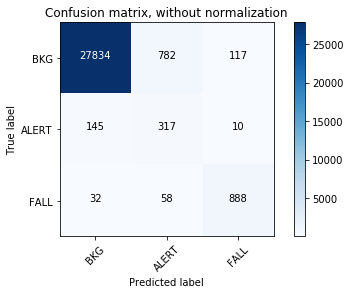

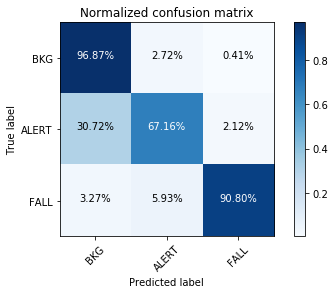

In [80]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(ex_model_info['eval_results'], classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [84]:
for i in range(8):
    
    _id = i+1
    print('Model #{} acc:'.format(_id))
    
    ex_model_info = np.load(route + model_base_name +  '_model_id_' + str(_id) + '_info.npy')
    ex_model_info = ex_model_info[()]
    eval_results = ex_model_info['eval_results']
    
    acc_bkg = eval_results[0][0]/sum(eval_results[0])
    acc_ale = eval_results[1][1]/sum(eval_results[1])
    acc_fal = eval_results[2][2]/sum(eval_results[2])
    acc_mean = (acc_bkg + acc_ale + acc_fal)/3
    
    print('BKG: {}, ALERT: {}, FALL: {}, mean: {}'.format(acc_bkg, acc_ale, acc_fal, acc_mean))

Model #1 acc:
BKG: 0.9741412313367904, ALERT: 0.6228813559322034, FALL: 0.8844580777096115, mean: 0.8271602216595352
Model #2 acc:
BKG: 0.9738628058330143, ALERT: 0.5444915254237288, FALL: 0.876278118609407, mean: 0.7982108166220501
Model #3 acc:
BKG: 0.9774475341941322, ALERT: 0.6186440677966102, FALL: 0.9130879345603272, mean: 0.8363931788503566
Model #4 acc:
BKG: 0.9738280026450423, ALERT: 0.5466101694915254, FALL: 0.8558282208588958, mean: 0.7920887976651545
Model #5 acc:
BKG: 0.977169108690356, ALERT: 0.6186440677966102, FALL: 0.9253578732106339, mean: 0.8403903498992
Model #6 acc:
BKG: 0.9642919291407093, ALERT: 0.6440677966101694, FALL: 0.9141104294478528, mean: 0.8408233850662438
Model #7 acc:
BKG: 0.9719486304945533, ALERT: 0.6016949152542372, FALL: 0.9253578732106339, mean: 0.8330004729864747
Model #8 acc:
BKG: 0.9687119340131556, ALERT: 0.6716101694915254, FALL: 0.9079754601226994, mean: 0.8494325212091268
